# DNN - Assigment 1
#### Kamil Tokarski kt361223


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


BATCH_SIZE = 64
CLASSES_NO = 28
EPOCHS_NO = 15


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
DATA_PATH = './data/'
TRAIN_PATH = DATA_PATH + 'train/'
TEST_PATH = DATA_PATH + 'test/'


# Normalize inputs from [0, 1] to [-1, 1] (this is somewhat consistent 
# with the latent layers being batch normalized around 0 with unitary variance)
input_transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


def plot(samples):
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow((sample.permute(1, 2, 0) + 1) / 2)

    return fig


def load_traindata(batch_size=BATCH_SIZE):
    dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_PATH,
        transform=input_transform,
    )
    return dataset, torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )

samples 11200
{0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400, 10: 400, 11: 400, 12: 400, 13: 400, 14: 400, 15: 400, 16: 400, 17: 400, 18: 400, 19: 400, 20: 400, 21: 400, 22: 400, 23: 400, 24: 400, 25: 400, 26: 400, 27: 400}
torch.Size([64, 3, 250, 250])


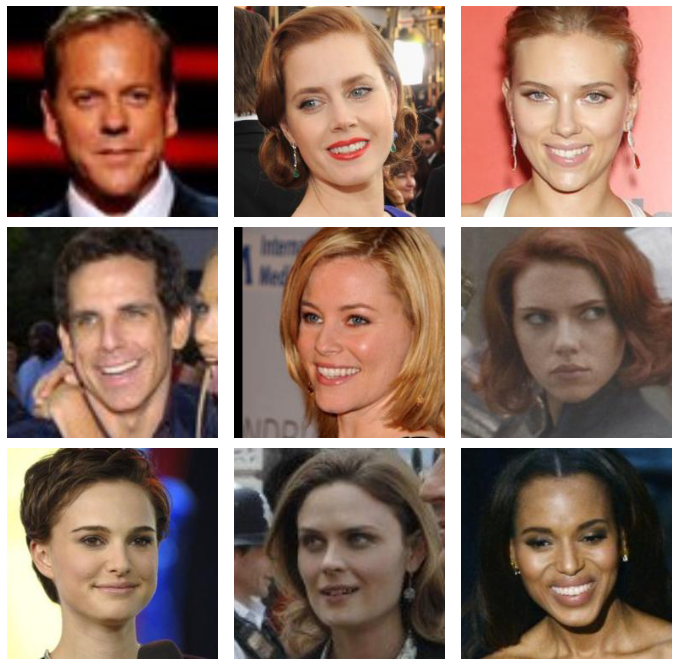

In [3]:

train_dataset, train_loader = load_traindata()

_, (image_batch, targets) = next(enumerate(train_loader))
plot([image_batch[i, :, :, :] for i in range(0, 9)])

print("samples {}".format(len(train_dataset.targets)))
classes_count = {
    k: 0 for k in 
    train_dataset.class_to_idx.values()
}
for t in train_dataset.targets:
    classes_count[t] = classes_count[t] + 1
print(classes_count)

print(image_batch.shape)

## Few words on the dataset (task 1)

All the classes are balanced with respect to samples number per class. That would be all the good news in this regard, because there are multiple challenges here:
* many images are blurred
* some images are grayscale
* a few images seem to be in the wrong class (is there a guy from monty python pretending to be an actress?)
* there are images where there are two or more faces (partially) visible in the picture
* people wear medical masks, hats, sunglasses, huge closed headphones etc
* some makeups make it quite difficult to recognize the person - there's a blue guy for instance
* pictures were taken from different angels

On the other hand, most of the aforementioned sound like rather true-to-life circumstances. I don't expect the model to learn how to classify blue people based on single picture of the blue guy but treating it as a noise, I still expect some sensible results from all the other images. To sum up, around 75-80% (based on the requirements for the Problem solution seems to be resonable accuracy to anticipate).


In [4]:
test_dataset = torchvision.datasets.ImageFolder(
    root=TEST_PATH,
    transform=input_transform,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


# sanity check for same classification of data in both datasets
assert(test_dataset.class_to_idx == train_dataset.class_to_idx)


def test_net(net):
    correct = 0
    total = 0
    # I could call here net.eval to switch into testing mode
    # but there are not statistics for batch normalizations 
    # stored in my implementation so it doesn't matter really
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct, total

## The *best* model (task 2)

In the cell below there's an implementation of the best model I managed to come up with, taking into account limited capabilites of my ancient gpu. Training it takes some time so I literally copied here the log from training time so that you can have a qucik look at the learning speed. Of course it still can be trained from scratch.

Model has over 79% accuracy on test dataset. My batch normalization is simplified and does not keep track of training statistics, that's why it's super important to provide test data shuffeld and with similar batch size. Otherwise test accuracy drops to around 30% (the discrepancy is still surprising for me even though I get why it happens).

After merely looking at the pictures and realizing many of them seem to be upscaled from lower size (blurred and distorted) I've chosen to increase nuber of channels mainly in the second and third layer when my naked eye can: 
1. on the one hand still tell what's what in the picture and on the other 
2. distorions seem to be less striking in that scale.

Kernel sizes, strides are all default, I did not find any reason to modify them in this setting. I don't use padding as I don't have any particualr reason for preserving the size of the pictures.

I am using 4 convolutional layers with pooling, and then two fully connected ones. Every hidden layer is batched normalized. There's cleary a yawning gap between utilizng batch normalization and not doing so (79% vs 64%). In the latter case I had to restart training a few times for the model to even start learning anything. Weight decay (aparently in different ways) was crucial in both cases. More on that in the part 3.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

    
# based on https://pytorch.org/docs/stable/notes/extending.html
class BatchNormDense(nn.Module):
    def __init__(self, input_features, eps=1e-8):
        super(BatchNormDense, self).__init__()
        self.input_features = input_features

        self.gammas = nn.Parameter(torch.ones(input_features), requires_grad=True)
        self.betas = nn.Parameter(torch.zeros(input_features), requires_grad=True)
        self.eps = eps

    def forward(self, input):
        mean = torch.mean(input, 0)
        var = torch.mean((input - mean) ** 2, 0) # biased estimator
        sdev = torch.sqrt(var + self.eps)
        standarized = torch.div(input - mean, sdev)
        output = torch.mul(standarized, self.gammas) + self.betas
        return output

    def extra_repr(self):
        return 'input_features={}'.format(self.input_features)


class BatchNorm2D(nn.Module):
    def __init__(self, input_channels, eps=1e-8):
        super(BatchNorm2D, self).__init__()
        self.input_channels = input_channels

        self.gammas = nn.Parameter(torch.ones(input_channels), requires_grad=True)
        self.betas = nn.Parameter(torch.zeros(input_channels), requires_grad=True)
        self.eps = eps

    def forward(self, input):
#         if not self.training:
#             TODO could implement average statistics and use them in testing time
        mean = torch.mean(input, (0, 2, 3))
        mean = mean.reshape(1, -1, 1, 1).expand(input.shape)
        var = torch.mean((input - mean) ** 2, (0, 2, 3)) # biased estimator
        var = var.reshape(1, -1, 1, 1).expand(input.shape)
        sdev = torch.sqrt(var + self.eps)
        standarized = torch.div(input - mean, sdev)
        gammas = self.gammas.reshape(1, -1, 1, 1).expand(input.shape)
        betas = self.betas.reshape(1, -1, 1, 1).expand(input.shape)
        output = torch.mul(standarized, gammas) + betas
        return output

    def extra_repr(self):
        return 'input_features={}'.format(self.input_features)


class Net(nn.Module):
    
    def __init__(self, use_batch=True):
        super(Net, self).__init__()
        
        self.use_batch = use_batch
        self.flat_size = 32 * 13 * 13
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 4, 3, bias=False)
        self.batch1 = BatchNorm2D(4)
        self.conv2 = nn.Conv2d(4, 16, 3, bias=False)
        self.batch2 = BatchNorm2D(16)
        self.conv3 = nn.Conv2d(16, 32, 3, bias=False)
        self.batch3 = BatchNorm2D(32)
        self.conv4 = nn.Conv2d(32, 32, 3, bias=False)
        self.batch4 = BatchNorm2D(32)
                
        self.batch1, self.batch2, self.batch3, self.batch4 = (
            BatchNorm2D(4), BatchNorm2D(16), BatchNorm2D(32), BatchNorm2D(32)
        ) if use_batch else (None, ) * 4
        
        self.fc1 = nn.Linear(self.flat_size, 512, bias=False)
        self.batch_fc1 = BatchNormDense(512)
        self.fc2 = nn.Linear(512, CLASSES_NO)

    def forward(self, x):
        for conv, batch in zip(
            [self.conv1, self.conv2, self.conv3, self.conv4],
            [self.batch1, self.batch2, self.batch3, self.batch4],
        ):
            x = conv(x)
            if self.use_batch:
                x = batch(x)
            x = self.pool(F.relu(x))
        x = x.view(-1, self.flat_size)
        x = F.relu(self.batch_fc1(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return x


In [6]:
MODEL_SAVE_PATH = "./model/traning_state{}{}.pth"


def train(net, name, loss_fun, optimizer, resume_epoch=-1, train_loader=None):
    LOOP_STATS = 40

    if train_loader is None:
        _, train_loader = load_traindata()

    if resume_epoch > -1:
        net.load_state_dict(torch.load(
            MODEL_SAVE_PATH.format(name, resume_epoch), map_location=device
        ))

    for epoch in range(resume_epoch + 1, EPOCHS_NO):  # loop over the dataset multiple times

        correct, total = test_net(net)
        print("[%d %3f]" % (epoch, correct / total))

        running_loss = 0.
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fun(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i == 0 and epoch == 0:
                print('[%d, %5d] loss: %.3f' % (
                    epoch + 1, i + 1,
                    running_loss
                ))
            elif i % LOOP_STATS == LOOP_STATS - 1:
                print('[%d, %5d] loss: %.3f' % (
                    epoch + 1, i + 1,
                    running_loss / LOOP_STATS
                ))
                running_loss = 0.0
        torch.save(net.state_dict(), MODEL_SAVE_PATH.format(name, epoch +  1))

    print('Finished Training')

In [7]:
# With batch normalization

net = Net()
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-2)

train(net, 'batched', loss_fun, optimizer, resume_epoch=15)

Finished Training


In [8]:
# Without batch normalization

netnb = Net(use_batch=False)
netnb = netnb.to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(netnb.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-2)

train(netnb, 'withoutbatch', loss_fun, optimizer, resume_epoch=15)

Finished Training


## Expermients (task 3)

### Acuracy and batch normalization impact (after 15 epochs with batch size of 64)

* Batch normalization
    * Train data
        * Accuracy: 0.95
        * Loss 0.3443
    * Test data
        * Accuracy 0.791
        * Loss 0.8492
 
* Without batch normalization
    * Train data
        * Accuracy: 0,85
        * Loss: 0.7806
    * Test data
        * Accuracy: 0,65
        * Loss 1.1788

In batch normalized version it seems 79% could be difficult to outperform without further tuning, next epochs results oscillated around this values, without batch normalization model has still been learning so achieved 64% is probably not as good as it could be with some more time. Thus, batch normalization certainly affected learning speed but I cannot conclude if the model is in general unable to perform as good as normalized one.


### Batch size impact


In [9]:
def test_batches_size():
    for size in (8, 16, 32, 64, 128):
        netbs = Net()
        netbs = netbs.to(device)

        loss_fun = nn.CrossEntropyLoss()
        optimizer = optim.RMSprop(netbs.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-2)
        _, loader = load_traindata(size)

        train(netbs, 'batched_bs{}'.format(size), loss_fun, optimizer, train_loader=loader)

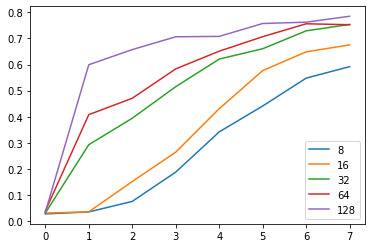

In [10]:
accs8 = [0.027778, 0.035354, 0.075758, 0.187951, 0.341991, 0.441198, 0.547980, 0.591991]
accs16 = [0.031025, 0.035714, 0.151876, 0.264430, 0.430736, 0.576840, 0.648629, 0.675325]
accs32 = [0.031025, 0.292929, 0.394300, 0.515152, 0.620851, 0.660534, 0.729076, 0.753608]
accs64 = [0.038961, 0.408009, 0.470779, 0.583333, 0.651154, 0.706710, 0.756133, 0.752525]
accs128 = [0.033911, 0.599206, 0.657287, 0.706349, 0.707792, 0.757215, 0.762266, 0.784993]

for accs in [accs8, accs16, accs32, accs64, accs128]:
    plt.plot(accs)

plt.legend(['8', '16', '32', '64', '128'])

As you can see batch size improves learning speed at the begining of the learning. Batch of size 8 failed to learn at all at the first attempt. It seems that batch size exceeding the number of classes results in significant improvement in the begining of training.


### Optimizers overview
I got best results with RMSprop optimizer. Plain SGD with momentum and Adam performed worse but I cannout rule out it's a matter of fortunate choice of hyperparameters in RMSprop. In training batch normalized version wieght_decay (L2 penalty) was crucial to jump above 75% accuracy (it seems that learning rate died too fast without it). Without batch normalization it seemed to be helpful as well, though presumably for different reasons.

## Results (task 4)

Once again, best model reached 79% accuracy on training set (compared to 64% without BN but one with BN didn't seem to be able to go any better from there whereas one withouth could possible still learn given more time)

Below I present consufion matrix for both models wehere you can see that the worse one had two classes that would be never predicted, the better one seems to be better balanced. I also present accuracy, recall and sensitivity of the models.

Testing classes are balanced which gives straightforawd interpretation of accuracy (there's no need to worry that model just prefers most frequent classes) and this way gets good accuracy. 

As it will be clear from the pictures there are some classes that model chooses more often but differences are not so huge.

In [11]:
def confusion(net):
    css = torch.zeros(CLASSES_NO, CLASSES_NO)
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            for p, l in zip(predicted, labels):
                css[p, l] += 1
    return css

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def conf_summury(cm):
    act_class = torch.sum(cm, 0).reshape(1, CLASSES_NO)
    pred_class = torch.sum(cm, 1)
    vmax = torch.max(pred_class).item()
    pred_class = torch.cat((pred_class, torch.sum(cm).reshape((1,))), 0)
    pred_class = pred_class.reshape(CLASSES_NO + 1, 1)
    rapp = torch.cat((cm, act_class), 0)
    return torch.cat((rapp, pred_class), 1), vmax


def draw_conf_matrix(cm, vmax=None):
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    df_cm = pd.DataFrame(cm.numpy(), range(29), range(29))
    plt.figure(figsize=(14,12))
    sn.set(font_scale=0.9) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt='g', vmax=vmax) # font size
    plt.show()


In [13]:
confnb = confusion(netnb)
confb = confusion(net)

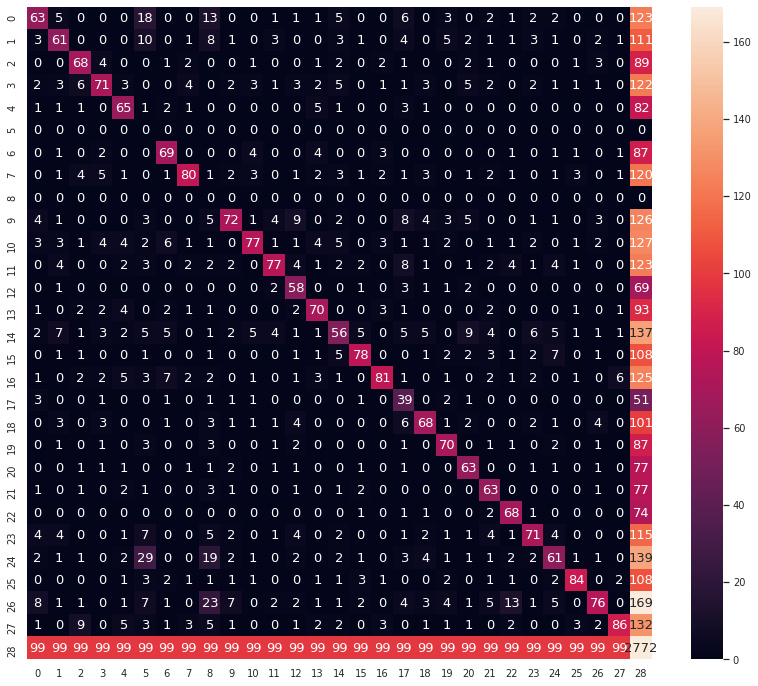

In [14]:
# confusion for the model without BN (for comparison)

cmnb, vmax = conf_summury(confnb)
draw_conf_matrix(cmnb, vmax=vmax)
pass

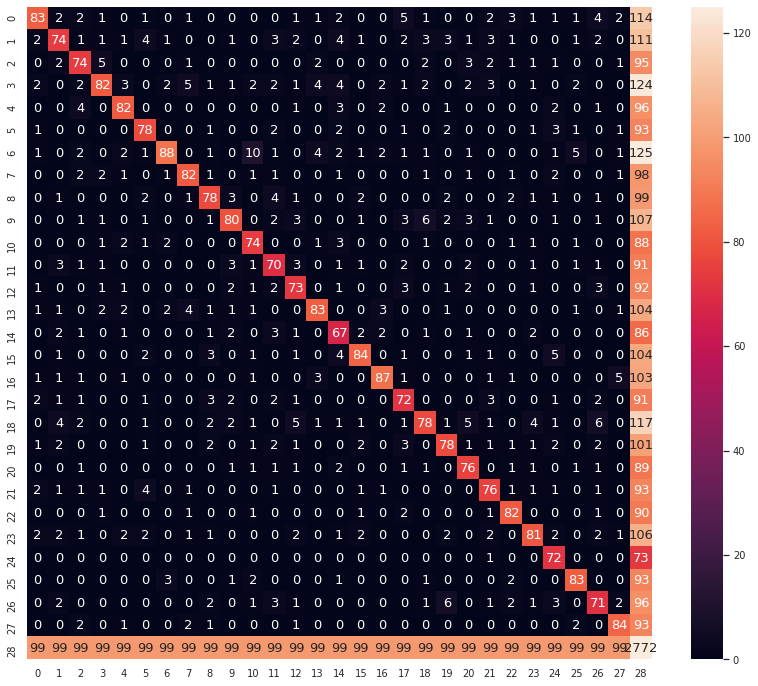

In [15]:
# confusion for the best model with BN (for comparison)

cm, vmax = conf_summury(confb)
draw_conf_matrix(cm, vmax)
pass

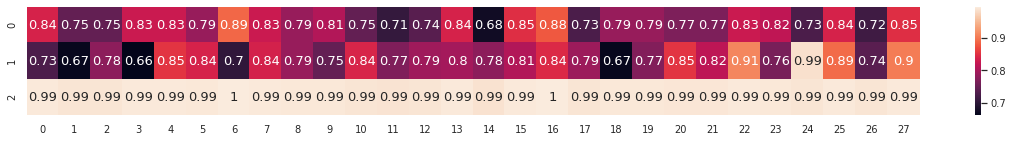

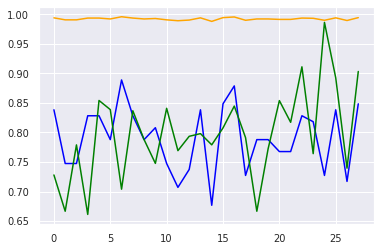

In [16]:
def draw_stats_matrix(cm):
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    df_cm = pd.DataFrame(cm.numpy(), range(3), range(28))
    plt.figure(figsize=(20,2))
    sn.set(font_scale=0.9) # fr label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 13}) # font size
    plt.show()


def stats(cm):
    tp_and_fp = torch.sum(cm, 1)
    p = torch.sum(cm, 0) # tp and fn
    tp = torch.tensor([cm[i, i] for i in range(cm.shape[0])])
    tpr = torch.div(tp, p) # sesnitivity (tpr) how many of the images of given actor has been properly labelled
    prec = torch.div(tp, tp_and_fp) # precision - how credibile is model saying that this is a given actor
    ns = [torch.sum(cm[:, [j for j in range(28) if j != i]]).item() for i in range(28)]
    fps = [torch.sum(cm[[j for j in range(28) if j != i], i]).item() for i in range(28)]
    specf = torch.tensor([1. - fp/n for n, fp in zip(ns, fps)]) # how much credible is a model 
                                        # saying that the photo doesn not belong to given class
    return [v.reshape((1, -1)) for v in [tpr, prec, specf]]

st = torch.cat(stats(confb), 0)
draw_stats_matrix(st)
plt.plot(st[0, :], color='blue')
plt.plot(st[1, :], color='green')
plt.plot(st[2, :], color='orange')
pass

So above you can see three parameters describing how well model performs on different classes: sensitivity, precision and specificity. 

* Sesnsitivity (0, blue) tells you what fraction of pictures from every class has been correctly labelled (if you were to use a model for search for the given actor in some set this is what percentage of pictures of them actually being there you would find). You can see that in most cases it is even above the accuracy of the model, there are a few classes that perform exceptionally worse which lowers a whole acuracy.

* Precision tells you how credible is model saying the there is a given actor in the picture, i.e. how many of pictures labelled as given actor actually are pictures of that actor. You can see some exceptioanlly good examples like the class number 24 - 99% pictures labelled as this actor actually were ones of them. Actor from class 7 has high precision and also avarage recall (sensitivity) at the high level. It is in contrast with class number 6 - there is above average recall for him but with poor precision, this mans that model is just overly prone to give this class as an answer.

* Maybe sligthly less interesting for us parameter is specificity (2, orange) that tells you what percentage of pictures of other actors hasn't been clasified as given actor. You can see it corresponds with precision for the given class.


Ok, so at the end, let's have a look at a few interesting classes:

In [17]:
test_dataset.class_to_idx

{'0000204': 0,
 '0000210': 1,
 '0000439': 2,
 '0000662': 3,
 '0001774': 4,
 '0004266': 5,
 '0004770': 6,
 '0004937': 7,
 '0005527': 8,
 '0006969': 9,
 '0010075': 10,
 '0010736': 11,
 '0068338': 12,
 '0177896': 13,
 '0221043': 14,
 '0221046': 15,
 '0358316': 16,
 '0424060': 17,
 '0515116': 18,
 '0519456': 19,
 '0688132': 20,
 '0829576': 21,
 '0913488': 22,
 '1015262': 23,
 '1312575': 24,
 '1374980': 25,
 '1415323': 26,
 '1433588': 27}

7 - very good precision and recall - model simply good in identifing this person


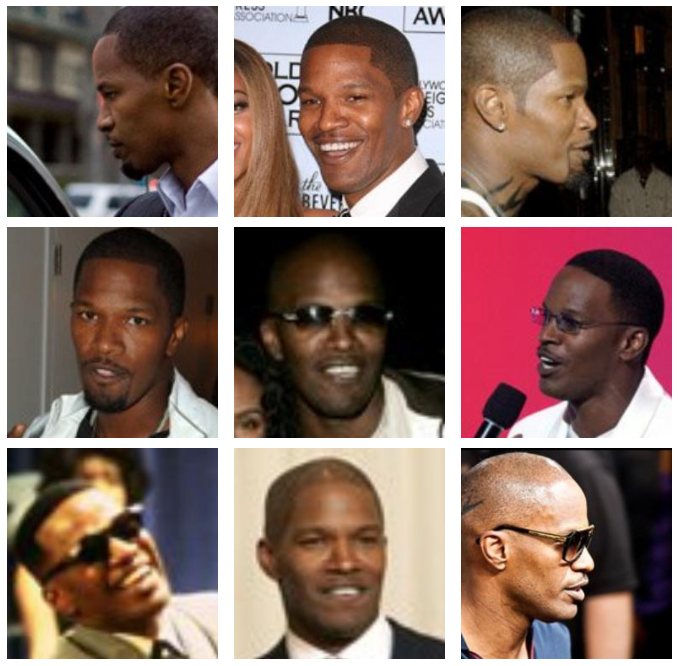

In [18]:
from PIL import Image
ims = map(input_transform, [Image.open('data/test/0004937/00{}.jpg'.format(i)) for i in range(1, 10)])
plot(ims)
print("7 - very good precision and recall - model simply good in identifing this person")

24 - very good precision with recall below average - once model decides its this actor it's mostly right


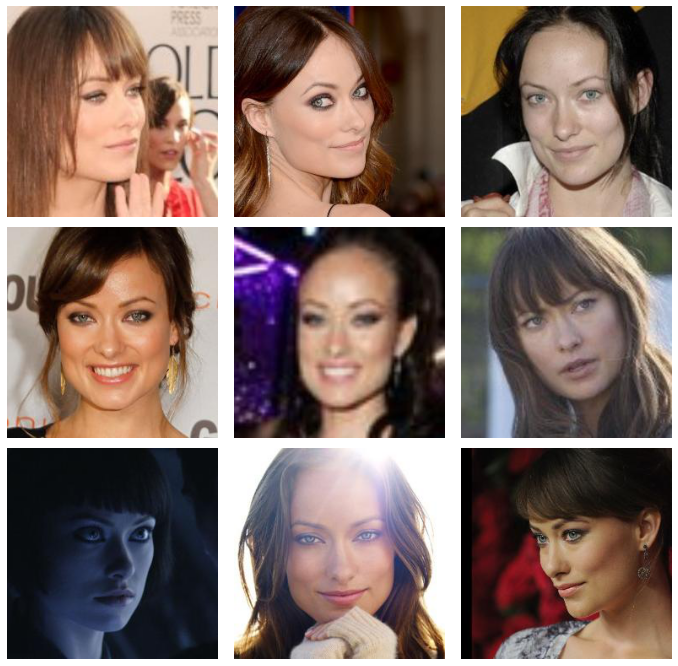

In [19]:
ims = map(input_transform, [Image.open('data/test/1312575/00{}.jpg'.format(i)) for i in range(1, 10)])
plot(ims)
print("24 - very good precision with recall below average - once model decides its this actor it's mostly right")

6 - high recall with bad precision - model overly prone to classify people to this class. Compare the class with the class that model confuses it with - could you tell them apart?


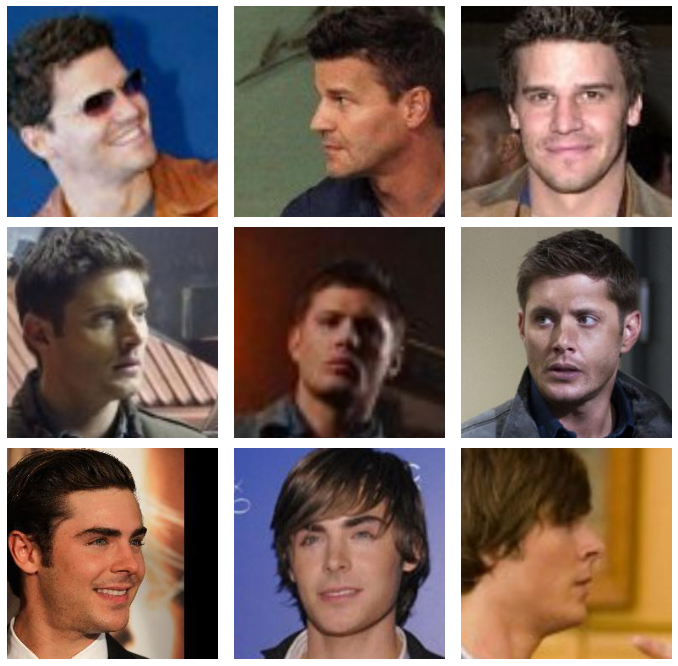

In [22]:
ims = map(input_transform, [
    Image.open('data/test/0004770/00{}.jpg'.format(i)) for i in range(1, 4)] + [
    Image.open('data/test/0010075/00{}.jpg'.format(i)) for i in range(1, 4)] + [
    Image.open('data/test/1374980/00{}.jpg'.format(i)) for i in range(1, 4)
])
plot(ims)
print("6 - high recall with bad precision - model overly prone to classify people to this class. Compare the class with the class that model confuses it with - could you tell them apart?")


1 - recall and precision below average - class dificult to tell apart from others. Can you tell them apart?


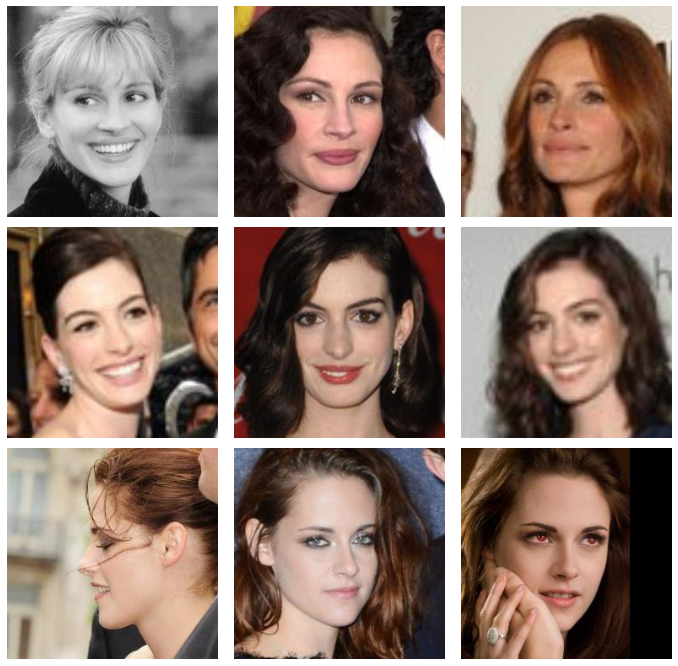

In [21]:
ims = map(input_transform, [
    Image.open('data/test/0000210/00{}.jpg'.format(i)) for i in range(1, 4)] + [
    Image.open('data/test/0004266/00{}.jpg'.format(i)) for i in range(1, 4)] + [
    Image.open('data/test/0829576/00{}.jpg'.format(i)) for i in range(1, 4)
])
plot(ims)
print("1 - recall and precision below average - class dificult to tell apart from others. Can you tell them apart?")